# Processing Raw Mobile Positioning Data (MPD)

## Summary

This notebook is used to process raw MPD. The process involves using `PySpark` to process raw mobile phone data from CSV/Parquet files. The data is read into Spark dataframes and transformed by rounding the `cell location data` and using reverse geocoding to obtain administrative location information. 

The data is preprocessed by `removing duplicates`, `anomaly subscribers`, and `remove random records`. Finally, the processed data is saved as a new CSV/Parquet file for further analysis. The goal of this process is to clean and transform the raw mobile phone data into a more usable format for analysis, allowing for valuable insights to be extracted from the data.

In general, MPD data is processed `regularly` every month, so it is assumed that the input data provided is separate for each month. This timeframe can be `readjusted` according to work objectives and the availability of resources to process data.

## Requirements

- PySpark installed on the local machine / PySpark Cluster with HDFS 

- Required packages and dependencies installed (pyspark, pandas, geopandas, folium)

- Raw mobile phone data (MPD) in CSV / Parquet Format.

**To run this notebook, you must install spark locally or having access to spark cluster, and install all packages dependency.** 

Please take a look into the [Environment Notebook: Mac & Linux Users](https://github.com/mandes95/893SSA-2022-BDT-DKH/blob/main/notebook/00-Setup%20Environment%20%5Bmac%20%26%20linux%5D.ipynb) or [Environment Notebook: Windows Users](https://github.com/mandes95/893SSA-2022-BDT-DKH/blob/main/notebook/00-Setup%20Environment%20%5Bwindows%5D.ipynb)

## Data Structure

To work with Mobile Positioning Data (MPD), the minimum required fields are listed below:

### Option 1: Records/Events Data Already Merged with Cells Location Data

| Field Name   | Type      | Mode     | Description                                          |
|--------------|-----------|----------|------------------------------------------------------|
| `msisdn`     | String    |          | Hashed subscribers identifier                        |
| `datetime`   | Timestamp |          | Transaction date (date and hour)                     |
| `cell_id`    | String    | NULLABLE | Hashed cell identifier                               |
| `latitude`   | Float     |          | Latitude of Base Transceiver Station (BTS)           |
| `longitude`  | Float     |          | Longitude of Base Transceiver Station (BTS)          |
| `data_type`  | String    |          | Data source, can be CDR/CHG or IPDR/UPCC             |
| `service`    | String    |          | Transaction service (4G/ 3G/ 2G)                     |

### Option 2: Records Data Not Merged with Cells Location Data

#### Records data

| Field Name   | Type      | Mode     | Description                                          |
|--------------|-----------|----------|------------------------------------------------------|
| `msisdn`     | String    |          | Hashed subscribers identifier                        |
| `datetime`   | Timestamp |          | Transaction date (date and hour)                     |
| `cell_id`    | String    |          | Hashed cell identifier                               |
| `data_type`  | String    |          | Data source, can be CDR/CHG or IPDR/UPCC             |

#### Cells Data

| Field Name   | Type      | Mode     | Description                                          |
|--------------|-----------|----------|------------------------------------------------------|
| `cell_id`    | String    |          | Hashed cell identifier                               |
| `latitude`   | Float     |          | Latitude of Base Transceiver Station (BTS)           |
| `longitude`  | Float     |          | Longitude of Base Transceiver Station (BTS)          |
| `service`    | String    |          | Transaction service (4G/ 3G/ 2G)                     |

To successfully run the processing of raw MPD using this notebook, please ensure to follow the same structure or adjust the script as needed. 

Moreover, additional information from the subscribers demography data will be nice to have for getting more informative information especially related to the gender and age group. 

**Note**: Please ensure the hashed cell ID is `consistent` with the records/events dataset so that it can be merged.

### Demography of Subscribers (additional)

Additionally, we can also add the user demography data (nice to have) to be merged with the records data so that it can be used for more detail analysis based on the gender or age_group of the subscribers.

| Field name   | Type   | Mode     | Description                                             |
|--------------|--------|----------|---------------------------------------------------------|
| `msisdn`     | String |          | Hashed subscribers identifier                           |
| `age`        | Int    |          | Subscribers age from registration data                  |
| `gender`     | String |          | Subscribers gender (M/F) from registration data         |

<br>

## Processing Steps

1. Initialize `Spark Session`, then read the `raw MPD` dataset using PySpark.

2. `Transform` the cell location by rounding the latitude and longitude values to a certain decimal place (4 decimal places, equal to accuracy ~11.1 m. [Ref.](http://wiki.gis.com/wiki/index.php/Decimal_degrees)). Will be useful if the cell ID information is missing.

3. `Exploratory data analysis (EDA)` that involves investigating and summarizing the main characteristics of raw MPD, such as the information about how many unique subscribers, records distribution, etc.

4. Preprocess the data by `removing duplicates`, `anomaly subscribers` (e.g. machine, tourist), and `fast movers/random records`.

5. `Save` the processed data as a new CSV or Parquet file for further analysis.

In [3]:
# Import the sys module to adjust the Python system path
import sys

# Append a path to the system path so that Python can import modules from the specified directory (relative path)
sys.path.append('../')

# Import the CONF, QA_summary and QA_action_plan variables from the script.QA module
from script.conf import BASE_PATH, CORE, RAW_FILE_PATH, RAW_MPD_PATH, RAW_CELL_PATH, RAW_CONF, FILTERED_FILE_PATH_PARQUET, FILTERED_FILE_PATH_CSV
RAW_FILE_PATH = "mpd_synthetic_data_20240510_with_null.csv"

In [4]:
# Import the os module to interact with the operating system
import os

# Try to create a new directory at the path QA_PATH using os.mkdir()
# If the directory already exists, print a message stating that it does
try:
    os.path.exists(BASE_PATH+RAW_FILE_PATH)
    USE_MERGED = True
except FileExistsError:
    USE_MERGED = False

print("Use Merged: {}".format(USE_MERGED))

Use Merged: True


## Start PySpark

In [37]:
# Import the PySpark module
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType

import pyspark.sql.functions as f
from pyspark.sql.functions import year, month, dayofmonth, substring, col, to_date
from pyspark.sql.window import Window

# Import the SparkSession from PySpark
from pyspark.sql import SparkSession

# if got error due to port configuration, run this script on terminal
# sudo hostname -s 127.0.0.1

# Create a SparkSession with the specified configuration local
spark = SparkSession.builder\
        .master("local[{}]".format(CORE))\
        .appName("01.ITU.PySpark-Raw")\
        .config('spark.sql.execution.arrow.pyspark.enabled', 'true')\
        .config('spark.eventLog.gcMetrics.youngGenerationGarbageCollectors', 'true')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Print the spark object which contains the SparkSession
spark

24/05/12 15:44:09 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


In [10]:
# Use this code below to connect your remote spark cluster instead.

# # Import the PySpark module
# import pyspark
# from pyspark.sql.types import StructType, StructField, StringType, FloatType, TimestampType

# import pyspark.sql.functions as f
# from pyspark.sql.functions import year, month, dayofmonth, substring, col, to_date
# from pyspark.sql.window import Window

# # Import the SparkSession from PySpark
# from pyspark.sql import SparkSession

# CLUSTER_URL = "spark://master"
# PORT = "7077"

# # Create a SparkSession with the specified configuration remote server
# spark = SparkSession.builder\
#         .master("{}:{}".format(CLUSTER_URL,PORT))\
#         .appName("01.ITU.PySpark-Raw")\
#         .getOrCreate()

# # Print the spark object which contains the SparkSession
# spark

## Read Raw MPD
The following code code sets a `BASE_PATH` variable to define the parent directory where data files are located. Then, it reads a specific CSV file into a `DataFrame` object using Apache Spark's `read()` method. 

If the available data is already in combined form (**option 1**), in this example refer to the CSV file `"MPD_sample.csv"`, which will be loaded from `BASE_PATH`. 

If the available data is still separated between records and cells (**option 2**), in this example refer to the CSV file `"MPD_sample_records.csv"` and `"MPD_sample_cells.csv"`, which will also be loaded from `BASE_PATH`. 

The resulting `DataFrame` is printed to display the first five rows in a tabular format, and then the total count of records in the `DataFrame` is printed using the `count()` method.

### Set MPD Schema

To import data using PySpark, its better to set specific classes by defines a schema for a set of mandatory columns in a data file using the `StructType()` class.

For This notebook, the schema is composed of seven mandatory MPD fields, each defined as a `StructField()` object that specifies the name, data type, and whether the field can contain null values. The available data types are specified by the imported classes (i.e., `StringType()`, `FloatType()`, and `TimestampType()`).

Once the `StructType()` object is created, it is assigned to the variable `MPDSchema_mandatory`, allowing it to be used elsewhere in the code.

### Option 1: Merged Data

In [38]:
if USE_MERGED:
  # Define a schema for a mandatory set of columns in a data file
  # Use StructType to create an object that defines the structure of the schema
  MPD_schema_mandatory = StructType([ \
      StructField("msisdn", StringType(), True), \
      StructField("datetime", TimestampType(), True), \
      StructField("cell_id", StringType(), True), \
      StructField("latitude", FloatType(), True), \
      StructField("longitude", FloatType(), True), \
      StructField("data_type", StringType(), True), \
      StructField("service", StringType(), True) \
    ])

  # Read in a CSV file using Apache Spark's DataFrame API
  # Set options including delimiter and header presence
  # Provide a schema using MPDSchema_mandatory variable defined elsewhere
  # Load the specified CSV file into a DataFrame
  df = spark.read.format('csv')\
      .options(delimiter=',')\
      .option('header',True)\
      .schema(MPD_schema_mandatory)\
      .load(BASE_PATH+RAW_FILE_PATH)

  # Display the first five rows of the DataFrame in a tabular format
  df.show(5)

  # Print the number of records in the DataFrame
  print("Number of records: {}".format(df.count()))

+------+-------------------+-------+--------+---------+---------+-------+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|
+------+-------------------+-------+--------+---------+---------+-------+
|     0|2024-05-10 05:36:00|  360.0|   43.21|   -3.129|     IPDR|     4G|
|     0|2024-05-10 07:33:00|  419.0|  43.217|   -3.122|     IPDR|     3G|
|     0|2024-05-10 08:31:00|  419.0|  43.217|   -3.122|     IPDR|     3G|
|     0|2024-05-10 09:33:00|  369.0|  43.218|   -3.128|     IPDR|     3G|
|     0|2024-05-10 10:57:00|  369.0|  43.218|   -3.128|     IPDR|     3G|
+------+-------------------+-------+--------+---------+---------+-------+
only showing top 5 rows

Number of records: 536851


### Option 2: Separated Data

In [11]:
if USE_MERGED==False:
  # Define a schema for a mandatory set of columns in a data file
  # Use StructType to create an object that defines the structure of the schema

  # records data schema
  MPD_record_schema_mandatory = StructType([ \
      StructField("msisdn", StringType(), True), \
      StructField("datetime", TimestampType(), True), \
      StructField("cell_id", StringType(), True), \
      StructField("data_type", StringType(), True), \
    ])

  # cells data schema
  MPD_cell_schema_mandatory = StructType([ \
      StructField("cell_id", StringType(), True), \
      StructField("latitude", FloatType(), True), \
      StructField("longitude", FloatType(), True), \
      StructField("service", StringType(), True) \
    ])

  # Read in a CSV file using Apache Spark's DataFrame API
  # Set options including delimiter and header presence
  # Load the records data using records schema
  df_records = spark.read.format('csv')\
      .options(delimiter=',')\
      .option('header',True)\
      .schema(MPD_record_schema_mandatory)\
      .load(BASE_PATH+RAW_MPD_PATH)

  # Load the cells data using cells schema
  df_cells = spark.read.format('csv')\
      .options(delimiter=',')\
      .option('header',True)\
      .schema(MPD_cell_schema_mandatory)\
      .load(BASE_PATH+RAW_CELL_PATH)

  # Joining two dataframes using left join on cell_id
  df = df_records.join(df_cells,df_records.cell_id ==  df_cells.cell_id,"left").drop(df_cells.cell_id)

  # Reorder columns
  df = df.select('msisdn','datetime','cell_id','latitude','longitude','data_type','service')

  # Display the first five rows of the DataFrame in a tabular format
  df.show(5)

  # Print the number of records in the DataFrame
  print("Number of records: {}".format(df.count()))

In [39]:
# display column names and types
df.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- cell_id: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- data_type: string (nullable = true)
 |-- service: string (nullable = true)



### Rounding Decimal And Create New Column

To start working with raw MPD, we need to rounding the decimal into standard precision (4 decimals, equal to 11.1 m) and create new column for identifying the date.

The code takes the DataFrame `df` and uses the `.withColumn()` method to add three new columns to it. The first two columns are 'latitude' and 'longitude', and they are created by rounding the existing 'latitude' and 'longitude' columns to 4 decimal places using the `f.round()` method from the PySpark SQL functions library (`f`), and then assigning these rounded values to the new columns.

The third column is 'date', which is created by converting the existing 'datetime' column to a date type using the `to_date()` function from the `pyspark.sql.functions` module, and then assigning the converted values to the new column.

In [40]:
# Round the 'latitude' column of the DataFrame `df` to 4 decimal places and create a new column called 'latitude' with the rounded values.
# Do the same for the 'longitude' column and create a new column called 'longitude' with the rounded values.
# Then convert the 'datetime' column to a date type and create a new column called 'date' with the converted values.

df = df\
    .withColumn(
        'latitude',f.round(col('latitude'),4) # round the 'latitude' column
    )\
    .withColumn(
        'longitude',f.round(col('longitude'),4) # round the 'longitude' column
    )\
    .withColumn(
        'date',to_date(col('datetime')) # convert the 'datetime' column to a date type
    )

# Show the first 5 rows of the updated DataFrame `df`.
df.show(5)


+------+-------------------+-------+--------+---------+---------+-------+----------+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|      date|
+------+-------------------+-------+--------+---------+---------+-------+----------+
|     0|2024-05-10 05:36:00|  360.0|   43.21|   -3.129|     IPDR|     4G|2024-05-10|
|     0|2024-05-10 07:33:00|  419.0|  43.217|   -3.122|     IPDR|     3G|2024-05-10|
|     0|2024-05-10 08:31:00|  419.0|  43.217|   -3.122|     IPDR|     3G|2024-05-10|
|     0|2024-05-10 09:33:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-10|
|     0|2024-05-10 10:57:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-10|
+------+-------------------+-------+--------+---------+---------+-------+----------+
only showing top 5 rows



### Drop Duplicate Rows

This code utilizes the `dropDuplicates()` method to efficiently eliminate duplicate rows from the data frame. 
By invoking this method, all duplicate rows are eradicated, leaving only a single instance of each unique row. If there are no changes observed before and after applying this operation, it signifies the absence of any duplicates in the data frame.

In [41]:
# detect duplicate rows
df_duplicates = df.groupBy(df.columns).count().filter("count > 1")
print(f"number of duplicate rows: {df_duplicates.count()}")
df_duplicates.show()

number of duplicate rows: 539


+------+-------------------+-------+--------+---------+---------+-------+----------+-----+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|      date|count|
+------+-------------------+-------+--------+---------+---------+-------+----------+-----+
|     8|2024-08-09 03:10:00|  164.0|  43.277|   -3.163|     IPDR|     3G|2024-08-09|    2|
|     8|2024-10-28 05:19:00|  164.0|  43.277|   -3.163|     IPDR|     3G|2024-10-28|    2|
|    15|2024-10-19 16:16:00|  935.0|  43.339|   -3.073|     IPDR|     3G|2024-10-19|    2|
|    23|2024-06-10 11:24:00|  182.0|  43.273|   -3.158|     IPDR|     3G|2024-06-10|    2|
|     3|2024-12-04 04:22:00|  890.0|  43.268|   -3.075|     IPDR|     3G|2024-12-04|    2|
|    15|2024-05-18 13:54:00|  936.0|  43.347|   -3.073|     IPDR|     3G|2024-05-18|    2|
|    25|2024-10-15 05:04:00|  753.0|  43.236|   -3.088|      CDR|     2G|2024-10-15|    2|
|     6|2024-08-01 17:26:00|   63.0|  43.364|   -3.188|     IPDR|     4G|2024-08-01|    2|

In [42]:
# Print the number of records in the DataFrame
print("Number of records before deduplication: {}\n".format(df.count()))

# Drops the duplicate rows from the dataframe
df = df.dropDuplicates()

# Display the first five rows of the DataFrame in a tabular format
df.show(5)

# Print the number of records in the DataFrame
print("Number of records after deduplication: {}".format(df.count()))

Number of records before deduplication: 536851



+------+-------------------+-------+--------+---------+---------+-------+----------+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|      date|
+------+-------------------+-------+--------+---------+---------+-------+----------+
|     0|2024-05-11 17:19:00|  419.0|  43.217|   -3.122|     IPDR|     3G|2024-05-11|
|     0|2024-05-19 03:01:00|  746.0|  43.327|   -3.089|     IPDR|     4G|2024-05-19|
|     0|2024-05-25 07:00:00|  873.0|  43.321|   -3.077|     IPDR|     3G|2024-05-25|
|     0|2024-05-29 11:13:00|  655.0|  43.327|     -3.1|     IPDR|     3G|2024-05-29|
|     0|2024-06-01 23:11:00|  786.0|  43.318|   -3.084|      CDR|     2G|2024-06-01|
+------+-------------------+-------+--------+---------+---------+-------+----------+
only showing top 5 rows



Number of records after deduplication: 536310


### Caching Data in PySpark

Caching data is a technique used in PySpark to improve the performance of iterative and interactive operations on large datasets. When you cache a DataFrame or RDD (Resilient Distributed Dataset), PySpark stores the data in memory and allows subsequent operations to access the data more quickly, avoiding the need to recompute or fetch the data from disk.

`Caching` a dataframe improves the `performance` of subsequent operations that use this dataframe as it avoids reading the data from disk on every operation. However, caching requires **extra memory** usage and should be used judiciously to avoid memory overflow issues.

When caching a DataFrame or RDD in PySpark, it's essential to understand the `active period` of the cache. The active period refers to the duration during which the data remains cached in memory and readily available for quick access.

By default, PySpark caches data in memory using a storage level called `MEMORY_AND_DISK`. This storage level ensures that the data is stored in memory as long as possible, but if the memory becomes insufficient, it spills the excess data to disk to avoid out-of-memory errors.

The active period of the cache starts when you explicitly cache the DataFrame or RDD using the cache() method. From that point onward, the cached data remains available for efficient retrieval by subsequent operations until one of the following events occurs:

- **Explicit Unpersist**: If you invoke the `unpersist()` method on the DataFrame or RDD, the cached data is immediately removed from memory, and the active period ends. 

- **Spark Context Termination**: When the Spark application or Spark Context terminates, either by explicitly stopping the context or when the application finishes execution, the active period of the cache ends. At this point, all cached data is automatically unpersisted, and the memory is released.

In [43]:
# The following code caches the dataframe in memory or on disk, if there's enough memory to hold all partitions of the dataframe.
df.cache()

DataFrame[msisdn: string, datetime: timestamp, cell_id: string, latitude: float, longitude: float, data_type: string, service: string, date: date]

### Exploratory Data Analysis (EDA)

`Exploratory Data Analysis (EDA)` is a crucial process in data science that involves investigating and summarizing the `primary characteristics` of a dataset. The main objective of EDA is to gain insights into the raw data and comprehend its underlying structure, identify patterns, detect anomalies, and develop hypotheses for further analysis.

When processing mobile positioning data, EDA involves examining the dataset to understand the available variables and their distributions, such as the number of unique subscribers, unique cell locations, and the distribution of records. This process can also help to identify any missing or erroneous values and diagnose general patterns within the data.

EDA is an essential step in preparing mobile positioning data for subsequent analysis as it identifies potential issues that require addressing, including data cleaning or imputation, and so on.

#### Checking Number of Unique Subscribers, Cell ID, Data type, & Services

The following operations are performed:
1. Four columns ('msisdn', 'cell_id', 'data_type', and 'service') are selected from the dataframe `df`, which we want to analyze.
2. `countDistinct()` function is applied on each of these columns to get the count of unique entities present in them.
3. The obtained values are then renamed, using `alias()` method, to better represent their count metrics.
4. `show()` method is used to display the resulting table in the console.

In [44]:
# Selects four columns from the dataframe df and counts their distinct values to get insights about unique subscribers, cell ids, data types and services.
df.select(
      f.countDistinct(col('msisdn')).alias('unique_subscribers'), # Counting distinct values of 'msisdn' column and giving it an alias name 'unique_subscribers'
      f.countDistinct(col('cell_id')).alias('unique_cell_id'), # Counting distinct values of 'cell_id' column and giving it an alias name 'unique_cell_id'
      f.countDistinct(col('data_type')).alias('unique_data_type'), # Counting distinct values of 'data_type' column and giving it an alias name 'unique_data_type'
      f.countDistinct(col('service')).alias('unique_service') # Counting distinct values of 'service' column and giving it an alias name 'unique_service'
  ).show() # Displaying the resulting dataframe using show() method

+------------------+--------------+----------------+--------------+
|unique_subscribers|unique_cell_id|unique_data_type|unique_service|
+------------------+--------------+----------------+--------------+
|               100|           938|               2|             3|
+------------------+--------------+----------------+--------------+



#### Checking the range of datetime, latitude, & Longitude

This code generates the range values for datetime, latitude, and longitude columns in a given dataframe. 

It does this by performing the following operations:
1. Selecting specific columns from the data frame using `select()`, with each selected value having an alias to rename it.
2. Using PySpark's built-in SQL functions `min()` and `max()` along with PySpark's `col()` function to select the minimum and maximum values of datetime, latitude, and longitude respectively in the data frame.
3. Renaming each of these selected minimum and maximum values as per their column name with the `alias()` method.
4. Finally, displaying all the selected and renamed values using the `show()` method.

In [46]:
# Generate the range value of datetime, latitude, and longitude
df_range = df\
    .select(
        # Selects the minimum value of 'datetime' column and renames it to 'min_datetime'
        f.min(col('datetime')).alias('min_datetime'),
        # Selects the maximum value of 'datetime' column and renames it to 'max_datetime'
        f.max(col('datetime')).alias('max_datetime'),
        # Selects the minimum value of 'latitude' column and renames it to 'min_latitude'
        f.min(col('latitude')).alias('min_latitude'),
        # Selects the minimum value of 'longitude' column and renames it to 'min_longitude'
        f.min(col('longitude')).alias('min_longitude'),
        # Selects the maximum value of 'latitude' column and renames it to 'max_latitude'
        f.max(col('latitude')).alias('max_latitude'),
        # Selects the maximum value of 'longitude' column and renames it to 'max_longitude'
        f.max(col('longitude')).alias('max_longitude'),
    )

df_range.show() 

+-------------------+-------------------+------------+-------------+------------+-------------+
|       min_datetime|       max_datetime|min_latitude|min_longitude|max_latitude|max_longitude|
+-------------------+-------------------+------------+-------------+------------+-------------+
|2024-05-10 00:00:00|2024-12-27 14:16:00|        43.2|         -3.2|      43.366|       -3.064|
+-------------------+-------------------+------------+-------------+------------+-------------+



In [47]:
# Importing the folium library for creating interactive maps.
import folium

# Selecting specific columns from the dataframe and dropping duplicate entries based on latitude and longitude. Converting the result to a Pandas dataframe.
df_cell_used = df.select(['cell_id','latitude','longitude']).dropDuplicates(['latitude','longitude']).toPandas()

# Converting the df_range dataframe to a Pandas dataframe for further processing.
df_range_pd = df_range.toPandas()

# Defining the coordinates for the corners of a rectangular area.
upper_left = (df_range_pd['min_latitude'].iloc[0], df_range_pd['min_longitude'].iloc[0])
upper_right = (df_range_pd['max_latitude'].iloc[0], df_range_pd['min_longitude'].iloc[0])
lower_left = (df_range_pd['min_latitude'].iloc[0], df_range_pd['max_longitude'].iloc[0])
lower_right = (df_range_pd['max_latitude'].iloc[0], df_range_pd['max_longitude'].iloc[0])

# Storing the corner coordinates in a list representing the edges of the rectangular area.
edges = [upper_left, upper_right, lower_right, lower_left]

# Creating a folium map centered at a specified location with a defined zoom level and using a specific tileset.
cell_location = folium.Map(
    location=[df_range_pd['min_latitude'].iloc[0], df_range_pd['min_longitude'].iloc[0]], # Centering the map at the minimum latitude and longitude coordinates.
    zoom_start=10,  # Setting the initial zoom level of the map.
    tiles="Cartodb Positron"  # Using the "Cartodb Positron" tileset for the map.
)

# Adding a polygon to the map, representing the rectangular area defined by the edges with specified color and fill properties.
folium.Polygon(locations=edges, color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(cell_location)
# folium.Rectangle(bounds=edges, color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(cell_location)

# Iterating through the rows of the df_cell_used dataframe and adding markers to the map for each cell tower location.
for i, row in df_cell_used.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],  # Specifying the coordinates of the marker based on its latitude and longitude.
        popup=row['cell_id'],  # Displaying the tower ID as the popup message.
        icon=folium.Icon(icon='signal')  # Defining the icon to use for each marker (signal).
    )\
    .add_to(cell_location)  # Adding the marker to the map.

# Displaying the final map with all the added elements (polygon and markers).
cell_location


### Explore Records Distribution

The code below will group a dataframe called `df` by the `'msisdn'` column and computes various count functions for other columns. 

The resulting dataframe `df_user_dist` is created using Apache Spark SQL `groupBy()` method, which groups the data by 'msisdn' column. Then it applies several aggregate functions to each group of data using the `agg()` method. 

In particular, the following five aggregate functions are applied to different columns:
- `count(col('msisdn'))`: counts the number of non-null rows in the 'msisdn' column for each group
- `countDistinct(col('msisdn'))`: counts the number of distinct 'msisdn' values for each group
- `countDistinct(col('cell_id'))`: counts the number of distinct 'cell_id' values for each group
- `countDistinct(col('data_type'))`: counts the number of distinct 'data_type' values for each group
- `countDistinct(col('service'))`: counts the number of distinct 'service' values for each group

The resulting columns are then renamed to more meaningful names using the `alias()` method.

Finally, the result from spark dataframe is collected into pandas dataframe by using the `toPandas()` method. This data will be used for plotting the records distribution to identify anomaly subscribers such as robot or tourist.

The `.head()` method is called on the resulting pandas dataframe `df_user_dist` to display the first 5 rows of data from it.

In [48]:
# This code groups the dataframe df by 'msisdn' column and applies various count functions for other columns.
df_user_dist = df\
  .groupBy(['msisdn'])\
  .agg(
      # Counts the total number of records for each unique value of 'msisdn' and renames that column as 'records'
      f.count(col('msisdn')).alias('records'),
      # Counts the number of unique 'cell_id' values for each group and renames that column as 'unique_cell_id'
      f.countDistinct(col('date')).alias('unique_date'),
      # Calculate average number of records per day
      (f.col('records')/f.col('unique_date')).alias('avg_records_day'),
      # Counts the number of unique 'cell_id' values for each group and renames that column as 'unique_cell_id'
      f.countDistinct(col('cell_id')).alias('unique_cell_id'),
      # Counts the number of unique 'data_type' values for each group and renames that column as 'unique_data_type'
      f.countDistinct(col('data_type')).alias('unique_data_type'),
      # Counts the number of unique 'service' values for each group and renames that column as 'unique_service'
      f.countDistinct(col('service')).alias('unique_service')
  ).toPandas() # collect data from spark into pandas

df_user_dist.sort_values('avg_records_day',ascending=False)

,msisdn,records,unique_date,avg_records_day,unique_cell_id,unique_data_type,unique_service
58,92,6155,226,27.234513,248,2,3
29,5,6046,226,26.752212,277,2,3
75,36,5992,227,26.396476,346,2,3
45,60,5936,226,26.265487,258,2,3
73,20,5951,227,26.215859,320,2,3
...,...,...,...,...,...,...,...
10,64,4992,228,21.894737,36,2,3
69,9,5011,229,21.882096,72,2,3
25,47,5021,230,21.830435,63,2,3
35,75,4987,229,21.777293,54,2,3


To see the distribution of the records per subscribers, we can create a histogram of the 'records' column of df_user_dist data.

When analyzing the distribution of the number of records in Mobile Positioning Data (MPD), it's possible to observe certain patterns that may align with `common anomalies` that often occur. These patterns can provide insights into potential issues or irregularities within the data.

In a healthy dataset, the number of records may exhibit a relatively `uniform distribution` across different subscribers, locations, etc. This indicates a consistent and expected behavior of data collection. If there is a deviation from the uniform distribution, such as a significant difference in the number of records in some particular subscribers compared to the others, it may indicate an issue worth investigating. For example, a high frequency events from a subscribers in a single cell location could be due to the use of robot system to interact with mobile network.

<Axes: >

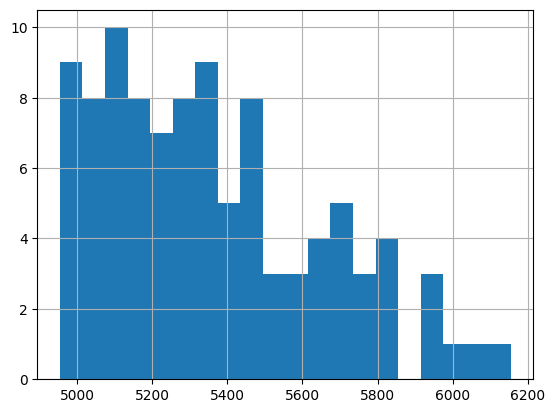

In [16]:
# Creates a histogram of the 'records' column of df_user_dist data frame with 20 bins
df_user_dist['records'].hist(bins=20)

After exploring the distribution at the user level, we can explore more deeper by checking the distribution at cell_id level for each subscribers, so that we can see more granular pattern and identify the potential anomaly subscribers inside the data, such as robots or tourist.

This code line performs the following tasks:

- It groups `df` by unique combinations of `'msisdn'`, `'date'`, and `'cell_id'` columns using `groupBy()` function.
- After grouping, it computes aggregation functions on each group. Here, it calculates the count of records for each unique combination of the three columns. Additionally, it counts the number of distinct entries in the 'data_type' and 'service' columns to get the number of unique data types and services in each group.
- Finally, it collects the aggregated data from Spark dataframe into a new Pandas dataframe using `toPandas()` function.

In [49]:
# Groups the df data frame by unique combinations of 'msisdn', 'date', and 'cell_id' columns
df_subs_cell_date = df \
  .groupBy(['msisdn','date','cell_id']) \
  .agg(
      # Counts the total number of records for each unique value of 'msisdn' and renames that column as 'records'
      f.count(col('msisdn')).alias('records'),
      # Counts the number of unique 'data_type' values for each group and renames that column as 'unique_data_type'
      f.countDistinct(col('data_type')).alias('unique_data_type'),
      # Counts the number of unique 'service' values for each group and renames that column as 'unique_service'
      f.countDistinct(col('service')).alias('unique_service')
  ).toPandas() # collect data from spark into pandas

# Sorts the resulting data frame by the 'records' column in descending order
df_subs_cell_date.sort_values('records',ascending=False)


,msisdn,date,cell_id,records,unique_data_type,unique_service
336349,58,2024-10-15,None,31,0,0
28776,3,2024-11-23,None,31,0,0
303161,70,2024-08-13,381.0,30,1,1
85110,87,2024-08-10,67.0,30,1,1
106722,3,2024-10-22,None,29,0,0
...,...,...,...,...,...,...
129953,54,2024-08-01,46.0,1,1,1
129954,26,2024-08-14,803.0,1,1,1
129955,95,2024-10-03,760.0,1,1,1
129956,81,2024-07-19,686.0,1,1,1


<Axes: >

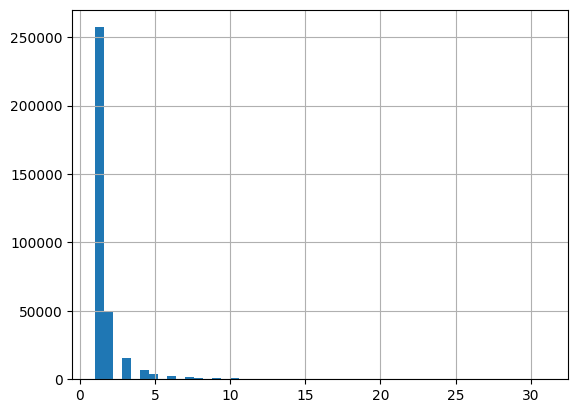

In [52]:
# Selects the 'records' column from the df_subs_patterns dataframe and plots a histogram with 100 bins
df_subs_cell_date['records'].hist(bins=50)

### Remove Anomaly Subscribers

#### Filtering Robot

Here, `df_subs_stats` is assumed to be a dataframe containing information about subscriber statistics, and `msisdn` is assumed to be one of the columns containing phone numbers. The code determines the subscribers who have made more than 500 (or configured threshold) events in a single site at a single day (which are treated as robots), calculates their percentage, and prints it out along with the total count. Finally, it provides the list of the first 10 msisdns (phone numbers) of those subscribers.

Step by step:
1. Selects a subset of data from a pandas dataframe `df_subs_stats` where the value in the column 'max_records' is greater than 500 and assigns it to a new dataframe called `df_robots`.
2. Calculates the number of rows in the `df_robots` dataframe and assigns it to a variable `n_robots`.
3. Calculates the percentage of subscribers who have more than 500 records in a single site at a single day and assigns it to a variable `prop_robots`.
4. Prints out the detection message of the detected number of subscribers and the corresponding percentage.
5. Shows the first 10 values of the `msisdn` column from the `df_robots` dataframe.


In [53]:
print("Robot Threshold: {}".format(RAW_CONF['ROBOT_THRESHOLD']))

Robot Threshold: 500


In [54]:
# Groups the df_subs_patterns dataframe by 'msisdn' and calculates aggregated statistics for the 'records' column
df_subs_cell_date_stats = df_subs_cell_date.groupby('msisdn').agg(
    min_records=('records','min'),
    med_records=('records','median'),
    max_records=('records','max')
).reset_index()

# Prints out the resulting dataframe
df_subs_cell_date_stats.sort_values('max_records',ascending=False)

,msisdn,min_records,med_records,max_records
54,58,1,1.0,31
23,3,1,4.0,31
86,87,1,2.0,30
68,70,1,1.0,30
18,25,1,2.0,28
...,...,...,...,...
9,17,1,1.0,5
45,5,1,1.0,5
57,60,1,1.0,5
47,51,1,1.0,5


<Axes: >

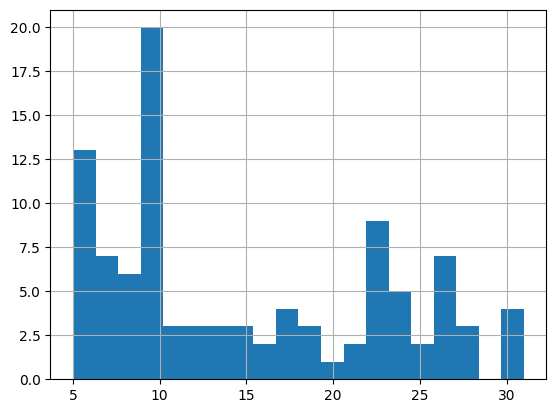

In [55]:
df_subs_cell_date_stats['max_records'].hist(bins=20)

In [56]:
# Select all rows from the DataFrame `df_subs_stats` where 'max_records' is greater than 500 and assign it to a new DataFrame called `df_robots`.
df_robots = df_subs_cell_date_stats[df_subs_cell_date_stats['max_records']>RAW_CONF['ROBOT_THRESHOLD']]

# Calculate the number of rows in the `df_robots` DataFrame and store the value in a variable called `n_robots`.
n_robots = len(df_robots)

# Calculate the percentage of robots (subscribers with more than 500 events in a single site at a single day) and store it in a variable called `prop_robots`.
prop_robots = n_robots/(len(df_subs_cell_date_stats))*100

# Print out detection message which shows the total number of detected robots and their percentage.
print('Detecting {} subscribers ({:.2f}%) with more than {} events in a single site at a single day.'.format(n_robots,prop_robots,RAW_CONF["ROBOT_THRESHOLD"]))

# Convert the first 10 values of the 'msisdn' column from the `df_robots` DataFrame into a list and print it.
df_robots['msisdn'].tolist()[:10]

Detecting 0 subscribers (0.00%) with more than 500 events in a single site at a single day.


[]

Filters out any rows from the original `df` DataFrame whose 'msisdn' values match any of the IDs listed in `df_robots`. The filtered DataFrame is assigned to `df_robot_filtered`.

In [57]:
# Filter out any rows from the DataFrame `df` that have 'msisdn' values that appear in the `anomaly_subscribers` list, and assign the resulting DataFrame to `df_filtered`.
df_robot_filtered = df.filter(~df.msisdn.isin(df_robots['msisdn'].unique().tolist()))

# Show the first 5 rows of the filtered DataFrame.
df_robot_filtered.show(5)

# Print out the count (total number of rows) in the filtered DataFrame.
print("Number of records before robot filtering: {}".format(df.count()))
print("Number of records after robot filtering: {}".format(df_robot_filtered.count()))

+------+-------------------+-------+--------+---------+---------+-------+----------+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|      date|
+------+-------------------+-------+--------+---------+---------+-------+----------+
|     0|2024-05-11 17:19:00|  419.0|  43.217|   -3.122|     IPDR|     3G|2024-05-11|
|     0|2024-05-19 03:01:00|  746.0|  43.327|   -3.089|     IPDR|     4G|2024-05-19|
|     0|2024-05-25 07:00:00|  873.0|  43.321|   -3.077|     IPDR|     3G|2024-05-25|
|     0|2024-05-29 11:13:00|  655.0|  43.327|     -3.1|     IPDR|     3G|2024-05-29|
|     0|2024-06-01 23:11:00|  786.0|  43.318|   -3.084|      CDR|     2G|2024-06-01|
+------+-------------------+-------+--------+---------+---------+-------+----------+
only showing top 5 rows



Number of records before robot filtering: 536310
Number of records after robot filtering: 536310


### Filter Random Events

This code creates a PySpark DataFrame `df_robot_filtered` and performs the following operations:
* Creates a window specification called `w_subs_site_date` that partitions data by columns `'msisdn'`, `'cell_id'`, and `'date'`.
* Uses the `withColumn()` method to add a new column called `'records_site'` to `df_robot_filtered`, which counts the number of records for each subscriber (`'msisdn'`) at each site (`'cell_id'`) per day (`'date'`). The `count()` function runs over the window specification `w_subs_site_date`.
* Filters the resulting DataFrame `df_robot_notrandom_filtered` to keep only the rows where the value in the `'records_site'` column is greater than 1.

In [24]:
print("Random Event Threshold: {}".format(RAW_CONF['RANDOM_EVENT_THRESHOLD']))

Random Event Threshold: 1


In [59]:
# Define a window object called `w_subs_site_date` that partitions by 'msisdn', 'cell_id', and 'date'
w_subs_site_date = Window.partitionBy(['msisdn', 'cell_id', 'date'])

# Create a new DataFrame `df_robot_notrandom_filtered` using `df_robot_filtered`
# Add a new column called 'records_site' using count() function with the window defined above
df_robot_notrandom_filtered = df_robot_filtered \
    .withColumn('records_site', f.count('data_type').over(w_subs_site_date))

# Print DataFrame and the number of records in it before filtering
print("Number of records before robot filtering: {}".format(df_robot_notrandom_filtered.count()))
df_robot_notrandom_filtered.show(10)

# Filter df_robot_notrandom_filtered to keep only rows where 'records_site' is greater than threshold
df_robot_notrandom_filtered = df_robot_notrandom_filtered.filter(col('records_site') > RAW_CONF["RANDOM_EVENT_THRESHOLD"])

# Print DataFrame and the number of records in it after filtering
df_robot_notrandom_filtered.show(10)

print("Number of the records after random records filtering: {}".format(df_robot_notrandom_filtered.count()))

Number of records before robot filtering: 536310


+------+-------------------+-------+--------+---------+---------+-------+----------+------------+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|      date|records_site|
+------+-------------------+-------+--------+---------+---------+-------+----------+------------+
|     0|2024-06-21 14:17:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-06-21|           2|
|     0|2024-06-21 15:57:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-06-21|           2|
|     0|2024-07-17 16:53:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-07-17|           1|
|     0|2024-10-02 15:00:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-10-02|           1|
|     0|2024-10-13 15:55:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-10-13|           1|
|     0|2024-05-10 05:36:00|  360.0|   43.21|   -3.129|     IPDR|     4G|2024-05-10|           1|
|     0|2024-05-13 16:16:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|
|     0|2024-05-13 0

+------+-------------------+-------+--------+---------+---------+-------+----------+------------+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|      date|records_site|
+------+-------------------+-------+--------+---------+---------+-------+----------+------------+
|     0|2024-06-21 14:17:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-06-21|           2|
|     0|2024-06-21 15:57:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-06-21|           2|
|     0|2024-05-13 16:16:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|
|     0|2024-05-13 08:10:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|
|     0|2024-05-13 17:05:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|
|     0|2024-05-13 08:59:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|
|     0|2024-05-13 02:28:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|
|     0|2024-05-13 1

Number of the records after random records filtering: 236580


### Filtering Tourists Subcribers

In here, tourist is defined as subscribers with less than 7 total events for all sites in a month within our targeted area of home and work location. For example, in a given month, Subscriber "A" only has 5 total events (visits to different locations) within the targeted area. Since this is less than 7, Subscriber "A" meets the criteria for being classified as a tourist.

The code selects all rows from the `df_subs_stats` DataFrame where the value in the 'max_records' column is less than 7 (or configured threshold), indicating that these subscribers have performed less than 7 events across all sites. It creates a new DataFrame called `df_tourists` to store these rows.

It then calculates the number of rows in the `df_tourists` DataFrame (representing the total number of "tourist" subscribers), as well as the percentage of all subscribers that fall into this category.

The exclusion of tourist data from the analysis of usual residence holds significance in ensuring an accurate representation of the local population, thereby enhancing the representativeness of the estimated percentage of internet usage in a specific area.

In [60]:
print("Tourist Threshold: {}".format(RAW_CONF['TOURIST_THRESHOLD']))

Tourist Threshold: 7


In [61]:
from pyspark.sql.functions import month

df_robot_notrandom_filtered = df_robot_notrandom_filtered.withColumn('month',month('datetime'))

df_subs_cell_month = df_robot_notrandom_filtered \
  .groupBy(['msisdn','month','cell_id','data_type','service']) \
  .agg(
      # Counts the total number of records for each unique value of 'msisdn' and renames that column as 'records'
      f.count(col('msisdn')).alias('records'),
      # Counts the number of unique 'data_type' values for each group and renames that column as 'unique_data_type'
      f.countDistinct(col('data_type')).alias('unique_data_type'),
      # Counts the number of unique 'service' values for each group and renames that column as 'unique_service'
      f.countDistinct(col('service')).alias('unique_service')
  ).toPandas() # collect data from spark into pandas

# Sorts the resulting data frame by the 'records' column in descending order
df_subs_cell_month.sort_values('records',ascending=False)

,msisdn,month,cell_id,data_type,service,records,unique_data_type,unique_service
18600,42,8,67.0,IPDR,4G,463,1,1
13,25,11,753.0,CDR,2G,442,1,1
9851,87,8,67.0,IPDR,4G,438,1,1
14387,25,10,753.0,CDR,2G,425,1,1
5360,25,8,753.0,CDR,2G,417,1,1
...,...,...,...,...,...,...,...,...
15132,46,12,138.0,IPDR,3G,2,1,1
5017,7,11,513.0,CDR,2G,2,1,1
5016,21,7,831.0,IPDR,3G,2,1,1
15136,86,11,85.0,IPDR,3G,2,1,1


In [62]:
# Groups the df_subs_patterns dataframe by 'msisdn' and calculates aggregated statistics for the 'records' column
df_subs_cell_month_stats = df_subs_cell_month.groupby('msisdn').agg(
    min_records=('records','min'),
    med_records=('records','median'),
    max_records=('records','max')
).reset_index()

# Prints out the resulting dataframe
df_subs_cell_month_stats.sort_values('max_records',ascending=False)

,msisdn,min_records,med_records,max_records
37,42,2,4.0,463
18,25,2,9.0,442
86,87,2,6.5,438
78,8,2,5.0,355
90,90,2,31.0,258
...,...,...,...,...
58,61,2,3.0,19
13,20,2,2.0,18
91,91,2,2.0,16
72,74,2,3.0,14


In [63]:
# Filter rows from `df_subs_cell_month_stats` to keep only those where 'max_records' is less than 7. 
df_tourists = df_subs_cell_month_stats[df_subs_cell_month_stats['max_records']<RAW_CONF['TOURIST_THRESHOLD']]

# Count the number of rows in `df_tourists`
n_tourists = len(df_tourists)

# Calculate the proportion of 'tourist' subscribers in `df_subs_cell_month_stats`
prop_tourists = n_tourists/(len(df_subs_cell_month_stats))*100

# Display a message about the number and proportion of subscribers identified as tourists,
# using f-string formatting to insert the values of `n_tourists` and `prop_tourists` into the message.
print('Detecting {} subscribers ({:.2f}%) with less than {} events from all sites.'.format(n_tourists,prop_tourists,RAW_CONF["TOURIST_THRESHOLD"]))

# Display the first 10 elements in the 'msisdn' column of the DataFrame 'df_tourists'
df_tourists['msisdn'].tolist()[:10]

Detecting 0 subscribers (0.00%) with less than 7 events from all sites.


[]

In [64]:
# Filter rows from `df_robot_notrandom_filtered` such that they do not contain any of the MSISDNs in `df_tourists`,
# and assign the result to a new DataFrame called `df_all_filtered`.
df_all_filtered = df_robot_notrandom_filtered.filter(~df_robot_notrandom_filtered.msisdn.isin(df_tourists['msisdn'].unique().tolist()))

# Show the first 5 records of the filtered DataFrame.
df_all_filtered.show(5)

# Print the number of rows in the final filtered DataFrame.
print("Number of records after all filtering: {}".format(df_all_filtered.count()))


+------+-------------------+-------+--------+---------+---------+-------+----------+------------+-----+
|msisdn|           datetime|cell_id|latitude|longitude|data_type|service|      date|records_site|month|
+------+-------------------+-------+--------+---------+---------+-------+----------+------------+-----+
|     0|2024-06-21 14:17:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-06-21|           2|    6|
|     0|2024-06-21 15:57:00|  338.0|  43.331|   -3.132|     IPDR|     3G|2024-06-21|           2|    6|
|     0|2024-05-13 16:16:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|    5|
|     0|2024-05-13 08:10:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|    5|
|     0|2024-05-13 17:05:00|  369.0|  43.218|   -3.128|     IPDR|     3G|2024-05-13|           9|    5|
+------+-------------------+-------+--------+---------+---------+-------+----------+------------+-----+
only showing top 5 rows



Number of records after all filtering: 236580


Finally, after finishing all the filtering process, we can save the filtered data to be used for the next steps. 

The data is partitioned by the column 'msisdn'. Partitioning is the process of dividing data into multiple smaller and manageable parts based on some criteria or column(s). In this case, partitioning is done on 'msisdn', which means that each unique value of 'msisdn' will be stored in a separate subdirectory in the output folder. Partitioning often helps with faster processing of large datasets by reading/writing only necessary partition(s) instead of the whole dataset.

The output data will be written to the directory specified by `'BASE_PATH'`, with the subdirectory name `'MPD_sample_synthetic_filtered'`. The exact path to the output directory depends on the value of `'BASE_PATH'`. 

In [39]:
df_all_filtered.show(5)

+-------------+--------------------+-------+--------+---------+---------+-------+----------+------------+-----+
|       msisdn|            datetime|cell_id|latitude|longitude|data_type|service|      date|records_site|month|
+-------------+--------------------+-------+--------+---------+---------+-------+----------+------------+-----+
|subscriber_10|2023-05-07 04:37:...|     13|-22.9145| -43.7425|     IPDR|     3G|2023-05-07|           2|    5|
|subscriber_10|2023-05-07 07:37:...|     13|-22.9145| -43.7425|      CDR|     3G|2023-05-07|           2|    5|
|subscriber_10|2023-05-05 12:10:...|     14|-22.7595| -43.4501|      CDR|     3G|2023-05-05|           2|    5|
|subscriber_10|2023-05-05 07:20:...|     14|-22.7595| -43.4501|      CDR|     3G|2023-05-05|           2|    5|
|subscriber_10|2023-05-05 12:59:...|     24|-22.9241| -43.1652|      CDR|     2G|2023-05-05|           2|    5|
+-------------+--------------------+-------+--------+---------+---------+-------+----------+------------

In [33]:
# Write the DataFrame `df_all_filtered` to disk in the Parquet file format using the `write` method.
# Before write the file, we can drop the records_site and month column since it will not be used in further analysis
# The data will be partitioned by the column 'msisdn' using the `partitionBy()` method.
# This means that each unique value of 'msisdn' will be stored in a separate subdirectory in the output folder.
# The output data will be written to the directory specified by 'BASE_PATH', with the subdirectory name 'MPD_sample_synthetic_filtered'.
df_all_filtered = df_all_filtered.drop('records_site').drop('month')

df_all_filtered\
    .write.mode("overwrite")\
    .partitionBy('msisdn')\
    .parquet(BASE_PATH+FILTERED_FILE_PATH_PARQUET)

In [34]:
df_all_filtered = df_all_filtered.drop('records_site').drop('month')

df_all_filtered\
    .coalesce(1)\
    .write.option("header",True)\
    .mode("overwrite")\
    .csv(BASE_PATH+FILTERED_FILE_PATH_CSV)

In [35]:
spark.stop()